# RSE(Random Self-Ensemble)によるFGSM attackへの防衛の検証



## 準備

In [1]:
# import pytorch and other libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms



In [2]:
# download CIFAR-10 dataset



transform = transforms.Compose(
    [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

batch_size = 512

trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


train_size = int(len(trainvalset) * 0.8) 
val_size = len(trainvalset) - train_size 


trainset, valset = torch.utils.data.random_split(trainvalset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 対策なしのモデル

In [3]:
# ニューラルネットワークの定義

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding='same')
        self.conv2 = nn.Conv2d(32, 32, 3, padding='same')
        self.conv3 = nn.Conv2d(32, 64, 3, padding='same')
        self.conv4 = nn.Conv2d(64, 64, 3, padding='same')
        self.bn1 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 128, 3, padding='same')
        self.conv6 = nn.Conv2d(128, 128, 3, padding='same')
        self.conv7 = nn.Conv2d(128, 256, 3, padding='same')
        self.conv8 = nn.Conv2d(256, 512, 3, padding='same')
        self.bn2 = nn.BatchNorm2d(512)

        self.fc1 = nn.Linear(512 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 10)

        return 

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        x = self.bn1(x)
        x = F.relu(x) 
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv7(x))
        x = (self.conv8(x))
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
    def predict(self,x,n=1):
        x = self.forward(x)
        return torch.argmax(x, dim=1)


2817706
device cuda:0
epoch: 1, train_loss: 1.6471, train_acc: 0.3868, val_loss: 1.3192, val_acc: 0.5225
epoch: 2, train_loss: 1.1352, train_acc: 0.5892, val_loss: 1.0512, val_acc: 0.6187
epoch: 3, train_loss: 0.8865, train_acc: 0.6834, val_loss: 0.8858, val_acc: 0.6846
epoch: 4, train_loss: 0.7255, train_acc: 0.7431, val_loss: 0.7595, val_acc: 0.7310
epoch: 5, train_loss: 0.5954, train_acc: 0.7913, val_loss: 0.7415, val_acc: 0.7399
epoch: 6, train_loss: 0.4787, train_acc: 0.8313, val_loss: 0.7104, val_acc: 0.7594
epoch: 7, train_loss: 0.3750, train_acc: 0.8688, val_loss: 0.7485, val_acc: 0.7586
epoch: 8, train_loss: 0.2954, train_acc: 0.8974, val_loss: 0.8131, val_acc: 0.7554
epoch: 9, train_loss: 0.1982, train_acc: 0.9326, val_loss: 0.8134, val_acc: 0.7677
epoch: 10, train_loss: 0.1386, train_acc: 0.9540, val_loss: 0.9026, val_acc: 0.7743
epoch: 11, train_loss: 0.1201, train_acc: 0.9586, val_loss: 0.9095, val_acc: 0.7743
epoch: 12, train_loss: 0.0873, train_acc: 0.9700, val_loss: 0.9

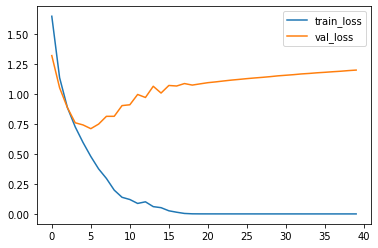

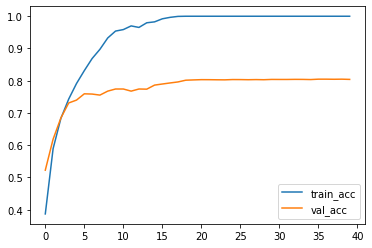

In [4]:
# モデルの定義
model = Net()


count_params = 0
for p in model.parameters():
    if p.requires_grad:
        count_params += p.numel()
        
print(count_params)  

# gpuを使う場合
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device",device)
model.to(device)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = optim.Adam(model.parameters(), lr=0.0005)

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

epochs = 40

# 学習
for epoch in range(epochs):  # loop over the dataset multiple times

    num_train_correct = 0
    train_loss = 0.0

    for inputs, labels in trainloader:

        # gpuを使う場合
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        predicted_label = torch.argmax(outputs, dim=1)
        num_train_correct += torch.sum(predicted_label == labels).item()
        train_loss += loss.item() * inputs.size(0)

        optimizer.step()
    
    train_loss = train_loss / len(trainset)
    train_acc = num_train_correct / len(trainset)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    num_val_correct = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in valloader:

            # gpuを使う場合
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            predicted_label = torch.argmax(outputs, dim=1)
            num_val_correct += torch.sum(predicted_label == labels).item()
            val_loss += loss.item() * inputs.size(0)
    
    val_loss = val_loss / len(valset)
    val_acc = num_val_correct / len(valset)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    

    print('epoch: {}, train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.format(epoch+1, train_loss, train_acc, val_loss, val_acc))

print('Finished Training')

# lossの推移を可視化
plt.plot(train_loss_list, label='train_loss')
plt.plot(val_loss_list, label='val_loss')

plt.legend()
plt.show()

# accの推移を可視化
plt.plot(train_acc_list, label='train_acc')
plt.plot(val_acc_list, label='val_acc')

plt.legend()
plt.show()







## FGSMを無対策モデルに行う

In [5]:
class FGSM():
    def __init__(self, model, criterion, eps=0.03):
        self.model = model
        self.criterion = criterion
        self.eps = eps

    def generate(self, inputs, labels):
        inputs.requires_grad = True
        outputs = self.model(inputs)
        loss = self.criterion(outputs, labels)
        loss.backward()
        inputs_grad = inputs.grad.data
        perturbed_inputs = inputs + self.eps * inputs_grad.sign()
        perturbed_inputs = torch.clamp(perturbed_inputs, 0, 1)
        return perturbed_inputs
    
    def evaluate(self,val_dataloader,n=10):
        num_correct = 0
        num_total = 0

        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            perturbed_inputs = self.generate(inputs, labels)
            predicted_label = self.model.predict(perturbed_inputs,n=n)
            num_correct += torch.sum(predicted_label == labels).item()
            num_total += len(inputs)

        return num_correct / num_total

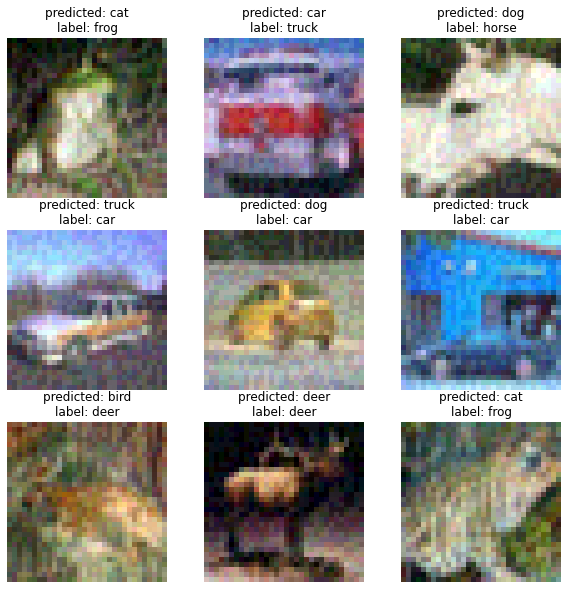

In [6]:
# FGSMの実行
fgsm = FGSM(model, criterion,0.05)
perturbed_inputs = fgsm.generate(inputs, labels)

classes = ('plane', 'car', 'bird', 'cat',
              'deer', 'dog', 'frog', 'horse', 'ship', 'truck')  

# 画像の可視化
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(perturbed_inputs[i].cpu().detach().numpy().transpose(1, 2, 0))
    # 予測されたラベルを表示
    ax.set_title(('predicted: {}'.format(classes[torch.argmax(model(perturbed_inputs[i].unsqueeze(0).to(device)), dim=1).item()]) +
    '\nlabel: {}'.format(classes[labels[i].item()])))
    ax.axis('off')
plt.show()

In [7]:
# fgsmにたいする耐性の評価
print('adv accuracy: {:.4f}'.format(fgsm.evaluate(testloader)))

# testデータに対する精度の評価
num_correct = 0
num_total = 0

for inputs, labels in testloader:
    inputs, labels = inputs.to(device), labels.to(device)
    predicted_label = model.predict(inputs)
    num_correct += torch.sum(predicted_label == labels).item()
    num_total += len(inputs)

print('normal accuracy: {:.4f}'.format(num_correct / num_total))


adv accuracy: 0.1985
normal accuracy: 0.7953


# RSE model

In [8]:
# ニューラルネットワークの定義

class NoiseLayer(nn.Module):
    def __init__(self, sigma):
        super(NoiseLayer, self).__init__()
        self.sigma = sigma

    def forward(self, x):
        noise = torch.randn_like(x) * self.sigma
        return x + noise #クリッピングかなと思ったけど論文には書いてないのと誤差逆のこともあるしちがうか
        



class RSENet(nn.Module):
    def __init__(self,init_sigma=0.2,other_sigma=0.1):
        super().__init__()

        self.init_noise = NoiseLayer(init_sigma)
        self.other_noise = NoiseLayer(other_sigma)

        self.conv1 = nn.Conv2d(3, 32, 3, padding='same')
        self.conv2 = nn.Conv2d(32, 32, 3, padding='same')
        self.conv3 = nn.Conv2d(32, 64, 3, padding='same')
        self.conv4 = nn.Conv2d(64, 64, 3, padding='same')
        self.bn1 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 128, 3, padding='same')
        self.conv6 = nn.Conv2d(128, 128, 3, padding='same')
        self.conv7 = nn.Conv2d(128, 256, 3, padding='same')
        self.conv8 = nn.Conv2d(256, 512, 3, padding='same')
        self.bn2 = nn.BatchNorm2d(512)

        self.fc1 = nn.Linear(512 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 10)

        return 

    def forward(self,x):
        x = self.init_noise(x)
        x = F.relu(self.conv1(x))
        x = self.other_noise(x)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.other_noise(x)
        x = F.relu(self.conv3(x))
        x = self.other_noise(x)
        x = (self.conv4(x))
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.other_noise(x)
        x = F.relu(self.conv5(x))
        x = self.other_noise(x)
        x = F.relu(self.conv6(x))
        x = F.max_pool2d(x, 2)
        x = self.other_noise(x)
        x = F.relu(self.conv7(x))
        x = self.other_noise(x)
        x = (self.conv8(x))
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
    def predict(self,x,n=10):
        # n回予測を行い、ensembleした結果を返す
        pred = torch.zeros(x.size(0),10).to(device)
        for i in range(n):
            pred += F.softmax(self.forward(x),dim=1)
        pred /= n
        return pred.argmax(dim=1)

epoch: 1, train_loss: 2.1706, train_acc: 0.1847, val_loss: 1.9378, val_acc: 0.2727
epoch: 2, train_loss: 1.8228, train_acc: 0.3213, val_loss: 1.7368, val_acc: 0.3586
epoch: 3, train_loss: 1.5993, train_acc: 0.4160, val_loss: 1.5002, val_acc: 0.4579
epoch: 4, train_loss: 1.4107, train_acc: 0.4963, val_loss: 1.3716, val_acc: 0.5198
epoch: 5, train_loss: 1.2815, train_acc: 0.5504, val_loss: 1.2507, val_acc: 0.5682
epoch: 6, train_loss: 1.1706, train_acc: 0.5955, val_loss: 1.1887, val_acc: 0.5975
epoch: 7, train_loss: 1.0809, train_acc: 0.6339, val_loss: 1.1039, val_acc: 0.6258
epoch: 8, train_loss: 1.0031, train_acc: 0.6671, val_loss: 1.0551, val_acc: 0.6484
epoch: 9, train_loss: 0.9379, train_acc: 0.6941, val_loss: 1.0177, val_acc: 0.6662
epoch: 10, train_loss: 0.8753, train_acc: 0.7178, val_loss: 0.9940, val_acc: 0.6755
epoch: 11, train_loss: 0.8250, train_acc: 0.7390, val_loss: 0.9901, val_acc: 0.6832
epoch: 12, train_loss: 0.7640, train_acc: 0.7612, val_loss: 0.9467, val_acc: 0.7022
e

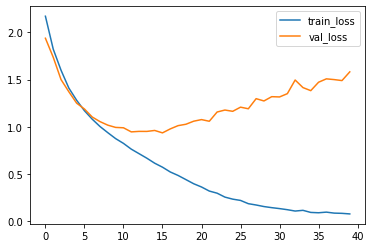

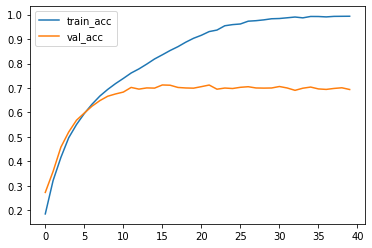

In [9]:
rsemodel = RSENet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rsemodel.parameters(), lr=0.0005)

# 学習()

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

epochs = 40

# 学習
for epoch in range(epochs):  # loop over the dataset multiple times

    num_train_correct = 0
    train_loss = 0.0

    for inputs, labels in trainloader:

        # gpuを使う場合
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize

        outputs = rsemodel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        predicted_label = rsemodel.predict(inputs)
        num_train_correct += torch.sum(predicted_label == labels).item()
        train_loss += loss.item() * inputs.size(0)

        optimizer.step()
    
    train_loss = train_loss / len(trainset)
    train_acc = num_train_correct / len(trainset)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    num_val_correct = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in valloader:

            # gpuを使う場合
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = rsemodel(inputs)
            loss = criterion(outputs, labels)

            predicted_label = rsemodel.predict(inputs)
            num_val_correct += torch.sum(predicted_label == labels).item()
            val_loss += loss.item() * inputs.size(0)
    
    val_loss = val_loss / len(valset)
    val_acc = num_val_correct / len(valset)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    

    print('epoch: {}, train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.format(epoch+1, train_loss, train_acc, val_loss, val_acc))

print('Finished RSE model Training')

# lossの推移を可視化
plt.plot(train_loss_list, label='train_loss')
plt.plot(val_loss_list, label='val_loss')

plt.legend()
plt.show()

# accの推移を可視化
plt.plot(train_acc_list, label='train_acc')
plt.plot(val_acc_list, label='val_acc')

plt.legend()
plt.show()
    





# RSE modelに対する攻撃

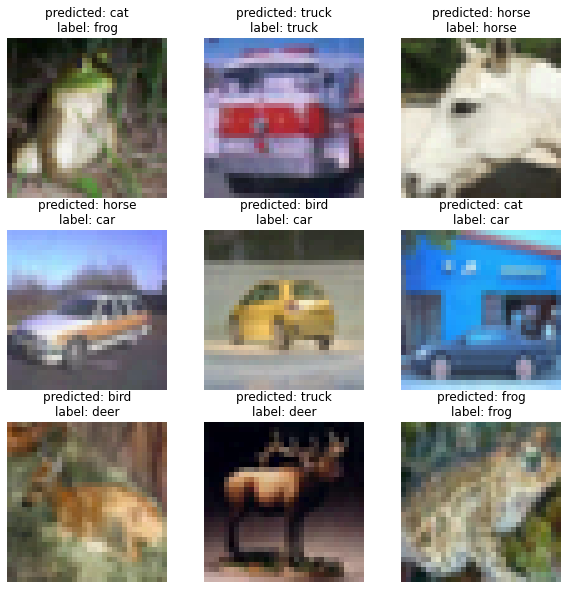

In [10]:
# FGSMの実行
fgsm = FGSM(rsemodel, criterion,0.010)
perturbed_inputs = fgsm.generate(inputs, labels)

classes = ('plane', 'car', 'bird', 'cat',
              'deer', 'dog', 'frog', 'horse', 'ship', 'truck')  

# 画像の可視化
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(perturbed_inputs[i].cpu().detach().numpy().transpose(1, 2, 0))
    # 予測されたラベルを表示
    ax.set_title(('predicted: {}'.format(classes[torch.argmax(rsemodel(perturbed_inputs[i].unsqueeze(0).to(device)), dim=1).item()]) +
    '\nlabel: {}'.format(classes[labels[i].item()])))
    ax.axis('off')
plt.show()

In [11]:
# fgsmにたいする耐性の評価
print('adv accuracy: {:.4f}'.format(fgsm.evaluate(testloader)))

# testデータに対する精度の評価
num_correct = 0
num_total = 0

for inputs, labels in testloader:
    inputs, labels = inputs.to(device), labels.to(device)
    predicted_label = rsemodel.predict(inputs)
    num_correct += torch.sum(predicted_label == labels).item()
    num_total += len(inputs)

print('normal accuracy: {:.4f}'.format(num_correct / num_total))

adv accuracy: 0.5656
normal accuracy: 0.6894


ensembleしなかったときにどうなるかも気になるな。あとtransformでの変形が0-1になってない。

In [12]:
# save models
torch.save(model.to("cpu").state_dict(), 'model3.pth')
torch.save(rsemodel.to("cpu").state_dict(), 'rsemodel3.pth')

# load models
model.load_state_dict(torch.load('model3.pth'))
rsemodel.load_state_dict(torch.load('rsemodel3.pth'))

model.to(device)
rsemodel.to(device)

RSENet(
  (init_noise): NoiseLayer()
  (other_noise): NoiseLayer()
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [13]:
# calc accuracy under FGSM for each epcilon
epsilons = [0, 0.01, 0.03, 0.05, 0.07, 0.1,0.12]
accuracies = []

from tqdm import tqdm

for eps in tqdm(epsilons):
    fgsm = FGSM(model, criterion, eps)
    acc = fgsm.evaluate(testloader)
    accuracies.append(acc)

print("model:",accuracies)

#rsemodelに対する精度の評価

epsilons = [0, 0.01, 0.03, 0.05, 0.07, 0.1,0.12]
rse_accuracies = {
    1 : [],
    5 : [],
    10 : [],
}

for n in rse_accuracies.keys():
    for eps in tqdm(epsilons):
        fgsm = FGSM(rsemodel, criterion, eps)
        acc = fgsm.evaluate(testloader,n)
        rse_accuracies[n].append(acc)
    
print("rsemodel:",rse_accuracies)


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


model: [0.7953, 0.5661, 0.3184, 0.1985, 0.1531, 0.1251, 0.112]


100%|██████████| 7/7 [00:36<00:00,  5.27s/it]

rsemodel: {1: [0.6724, 0.5575, 0.4187, 0.364, 0.3004, 0.2413, 0.2013], 5: [0.6818, 0.5637, 0.4221, 0.365, 0.3237, 0.2444, 0.204], 10: [0.6882, 0.5645, 0.4198, 0.3712, 0.3236, 0.2528, 0.2075]}


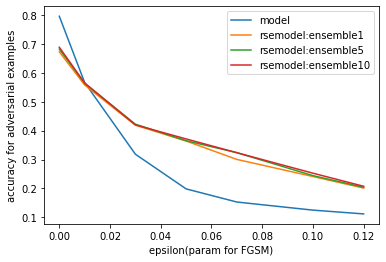

In [14]:
# 可視化
plt.plot(epsilons, accuracies, label='model')
for n in rse_accuracies.keys(): 
    plt.plot(epsilons, rse_accuracies[n], label=f'rsemodel:ensemble{n}')
plt.legend()
plt.xlabel('epsilon(param for FGSM)')
plt.ylabel('accuracy for adversarial examples')
plt.show()